In [1]:
import matplotlib.pyplot as plt
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial

import jaxlft

In [2]:
import haiku as hk
rns = hk.PRNGSequence(42)

# Download the data

Before running this notebook, the pretrained parameters must be downloaded from [here](https://doi.org/10.5281/zenodo.7547918).
This can be done either manually, or using the commands below:

In [10]:
!wget -q "https://zenodo.org/record/7547918/files/all-parameters.zip"

In [11]:
# unpack
!unzip -q "all-parameters.zip"

# Fixed coupling constant

In [12]:
lattice_size = 32  # choices: 6, 12, 20, 32, 64

In [13]:
# chosen to get correlation length ~ L / 4
lam_dict = {
    6: 6.975,
    12: 5.276,
    20: 4.807,
    32: 4.572,
    64: 4.398,
}

lam = lam_dict[lattice_size]

## Define model

In [14]:
model_def = jaxlft.cnf.Phi4CNF()

In [15]:
model = model_def.transform(lattice_shape=(lattice_size, lattice_size))

## Load parameters

In [16]:
data = np.load(f'all-parameters/single-L{lattice_size}.npz', allow_pickle=True)
params = hk.data_structures.to_immutable_dict(data['params'].item())

In [17]:
# faster sampling after jit-compiled
sample = jax.jit(model.sample, static_argnums=(2,))

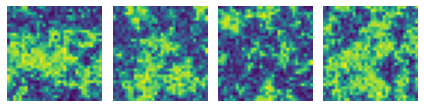

In [18]:
phi, logp = sample(params, next(rns), 4)

for i in range(4):
    plt.subplot(141 + i)
    plt.imshow(np.tanh(phi[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

## ESS

In [19]:
phi, logp = sample(params, next(rns), 256)

In [20]:
# target
theory = jaxlft.phi4.Phi4Theory(shape=(lattice_size, lattice_size), m2=-4, lam=lam)
logq = -theory.action(phi)

In [21]:
ess = jaxlft.effective_sample_size(logp, logq)
print(f'ESS for L={lattice_size}: {100*ess:.2f}%')

ESS for L=32: 90.38%


# Fixed coupling constant

In [22]:
lattice_size = 12  # choices: 12, 20, 32

In [23]:
lam_range = (4.0, 6.0)

## Define model

In [24]:
kernel = partial(jaxlft.cnf.KernelGauss, minmax=lam_range)
model_def = jaxlft.cnf.Phi4CNFConditional(lam_kernel_base=kernel)

In [25]:
model = model_def.transform(lattice_shape=(lattice_size, lattice_size))

In [26]:
data = np.load(f'all-parameters/range-L{lattice_size}.npz', allow_pickle=True)
params = hk.data_structures.to_immutable_dict(data['params'].item())

In [27]:
# faster sampling after jit-compiled
sample = jax.jit(model.sample, static_argnums=(2,))

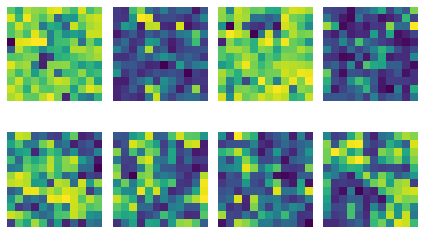

In [28]:
phi, logp = sample(params, next(rns), 4, lam=4.0)

for i in range(4):
    plt.subplot(241 + i)
    plt.imshow(jnp.tanh(phi[i]))
    plt.axis('off')


phi, logp = sample(params, next(rns), 4, lam=6.0)

for i in range(4):
    plt.subplot(245 + i)
    plt.imshow(jnp.tanh(phi[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

## ESS

In [29]:
lams = np.linspace(*lam_range, 7)
try:
    from tqdm import tqdm
    lams_iter = tqdm(lams)
except ImportError:
    lams_iter = lams

theory = jaxlft.phi4.Phi4Theory(shape=(lattice_size, lattice_size), m2=-4)

all_ess = []
for lam in lams_iter:
    phi, logp = sample(params, next(rns), 256, lam=lam)
    logq = -theory.action(phi, lam=lam)
    ess = jaxlft.effective_sample_size(logp, logq)
    all_ess.append(ess)

100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.74s/it]


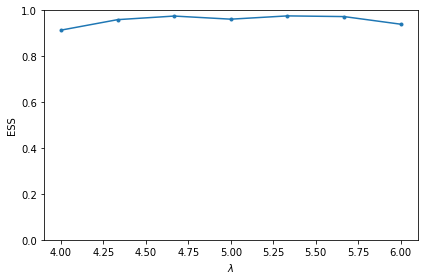

In [30]:
plt.plot(lams, all_ess, '.-')
plt.ylim(0, 1)
plt.xlabel('$\lambda$')
plt.ylabel('ESS')

plt.tight_layout()
plt.show()